# Setup

In [228]:
import os
os.chdir('../..')

In [2]:
import torch

from tqdm import tqdm
from torch import Tensor as _T

from ddpm.model.main.multiepoch import MultiPreparatoryHVAEReverseProcess

from ddpm.utils.loading import generate_model_and_task_from_args_path_multiepoch

from purias_utils.multiitem_working_memory.util.circle_utils import rectify_angles, polar2cart

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cmx
import matplotlib.colors as colors

import numpy as np
from scipy.spatial.distance import pdist

In [280]:

base_dir_name = 'hvae_with_dendritic_20250410'

device = 'cuda'


# analysis_args = ConfigNamepace.from_yaml_path(sys.argv[1], strict_access = True)
# yaml_name = sys.argv[1].split('/')[-1].split('.')[0]
# save_base = '/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/analysis/fixed_points'
# save_path = os.path.join(save_base, yaml_name)
# _, save_path, _ = configure_logging_paths(save_path, [])
# analysis_args.write_to_yaml(os.path.join(save_path, "args.yaml"))
# print(save_path)
# run_name = analysis_args.run_name


# run_name = 'run_a2_probe_cued_rnn_no_swap_1'
# run_name = 'run_a3_probe_cued_diffusion_no_swap_1'
# run_name = 'run_a4_probe_cued_diffusion_flat_swap_1'
run_name = 'run_a5_probe_cued_diffusion_cyclical_swap_0'
# run_name = 'run_a6_probe_cued_diffusion_sharp_swap_2'


_, task, ddpm_model, _, _ = generate_model_and_task_from_args_path_multiepoch(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/args.yaml', device)
ddpm_model.load_state_dict(torch.load(f'/homes/pr450/repos/research_projects/sampling_ddpm/results_link_sampler/{base_dir_name}/{run_name}/state.mdl', weights_only=True))
ddpm_model: MultiPreparatoryHVAEReverseProcess


for n, parameter in ddpm_model.named_parameters():
    parameter.required_grad = False


# Stimulus design

In [281]:
grid_points = 12
minimum_margin = torch.pi / task.task_variable_gen.min_sep

# Create unique feature values evenly spaced around the circle
unique_feature_values = torch.linspace(0, 2 * torch.pi, grid_points+1)[:-1]
unique_feature_values = rectify_angles(unique_feature_values)

# Create all possible combinations
stim1_grid, stim2_grid = torch.meshgrid(unique_feature_values, unique_feature_values, indexing='ij')
stim1_probe_features = stim1_grid.reshape(-1, 1)
stim2_probe_features = stim2_grid.reshape(-1, 1)

# Stack them together
all_probe_features = torch.cat([stim1_probe_features, stim2_probe_features], dim=1)
all_report_features = all_probe_features.clone()

all_probe_features = all_probe_features.unsqueeze(1).repeat(1, grid_points * grid_points, 1).reshape(grid_points ** 4, 2)
all_report_features = all_report_features.unsqueeze(0).repeat(grid_points * grid_points, 1, 1).reshape(grid_points ** 4, 2)

all_probe_features = all_probe_features.repeat(2, 1)
all_report_features = all_report_features.repeat(2, 1)

# Create mask for valid combinations (respecting minimum margin)
probe_angle_diff = rectify_angles(all_probe_features[:,0] - all_probe_features[:,1])
report_angle_diff = rectify_angles(all_report_features[:,0] - all_report_features[:,1])
valid_trial_mask = (probe_angle_diff.abs() >= minimum_margin) & (report_angle_diff.abs() >= minimum_margin)

selected_feature_idx = torch.concat([torch.zeros(grid_points ** 4), torch.ones(grid_points ** 4)]).int()
selected_feature_idx_valid_trials = selected_feature_idx[valid_trial_mask]

batch_size = valid_trial_mask.sum()
num_samples = 1

# Run trial

USING PRECUED ITEMS - SHOULD NEVER BE DONE IN TRAINING


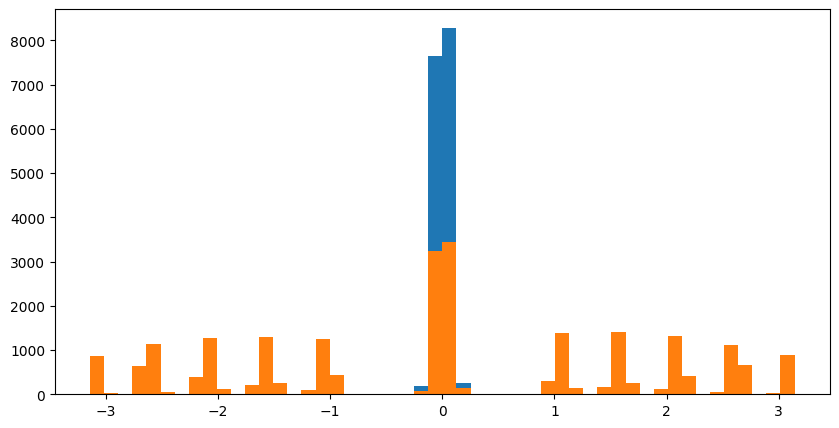

tensor(0.2961)


In [282]:
override_stimulus_features = {
    'probe_features': all_probe_features[valid_trial_mask],
    'report_features': all_report_features[valid_trial_mask],
}
override_stimulus_cart_features = {}
for k in override_stimulus_features.keys():
    override_stimulus_cart_features[f'{k}_cart'] = torch.stack(polar2cart(1.0, override_stimulus_features[k]), -1)

override_stimulus_features_dict = dict(
    **override_stimulus_features,
    **override_stimulus_cart_features,
    cued_item_idx = selected_feature_idx_valid_trials
)

task_variable_dict = task.task_variable_gen.generate_variable_dict(
    batch_size = batch_size,
    override_stimulus_features_dict=override_stimulus_features_dict
)

trial_information = task.generate_trial_information(
    batch_size=batch_size, num_samples=num_samples, override_task_variable_information = task_variable_dict
)

all_feature_data = torch.concat([
    trial_information.task_variable_information['probe_features_cart'].reshape(batch_size, 4),
    trial_information.task_variable_information['report_features_cart'].reshape(batch_size, 4),
], dim = -1)


with torch.no_grad():
    novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
        # prep_network_inputs=[
        #     pni[[0]] for pni in trial_information.prep_network_inputs
        # ],
        # diffusion_network_inputs=[
        #     dni[[0]] for dni in trial_information.diffusion_network_inputs
        # ],
        prep_network_inputs = trial_information.prep_network_inputs,
        diffusion_network_inputs = trial_information.diffusion_network_inputs,
        prep_epoch_durations=trial_information.prep_epoch_durations,
        diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
        samples_shape=[batch_size, num_samples],
        noise_scaler=1.0,
    )



actual_errors = rectify_angles(torch.arctan2(*novel_samples_dict['samples'].squeeze(1)[:,[1,0]].T) - all_report_features[valid_trial_mask][range(valid_trial_mask.sum()), selected_feature_idx[valid_trial_mask]]).numpy()
swapped_errors = rectify_angles(torch.arctan2(*novel_samples_dict['samples'].squeeze(1)[:,[1,0]].T) - all_report_features[valid_trial_mask][range(valid_trial_mask.sum()), 1 - selected_feature_idx[valid_trial_mask]]).numpy()

fig = plt.figure(figsize = (10, 5))
plt.hist(actual_errors, 50)
plt.hist(swapped_errors, 50)
plt.show()

swapped_trials = torch.tensor(np.abs(actual_errors) > np.abs(swapped_errors)).bool()
print(swapped_trials.float().mean())

# Report representation during delay

### Fix both probes and one report, then vary other report and seperate by probe

100%|██████████| 144/144 [00:02<00:00, 49.66it/s]


Text(0, 0.5, 'Swap probabilities')

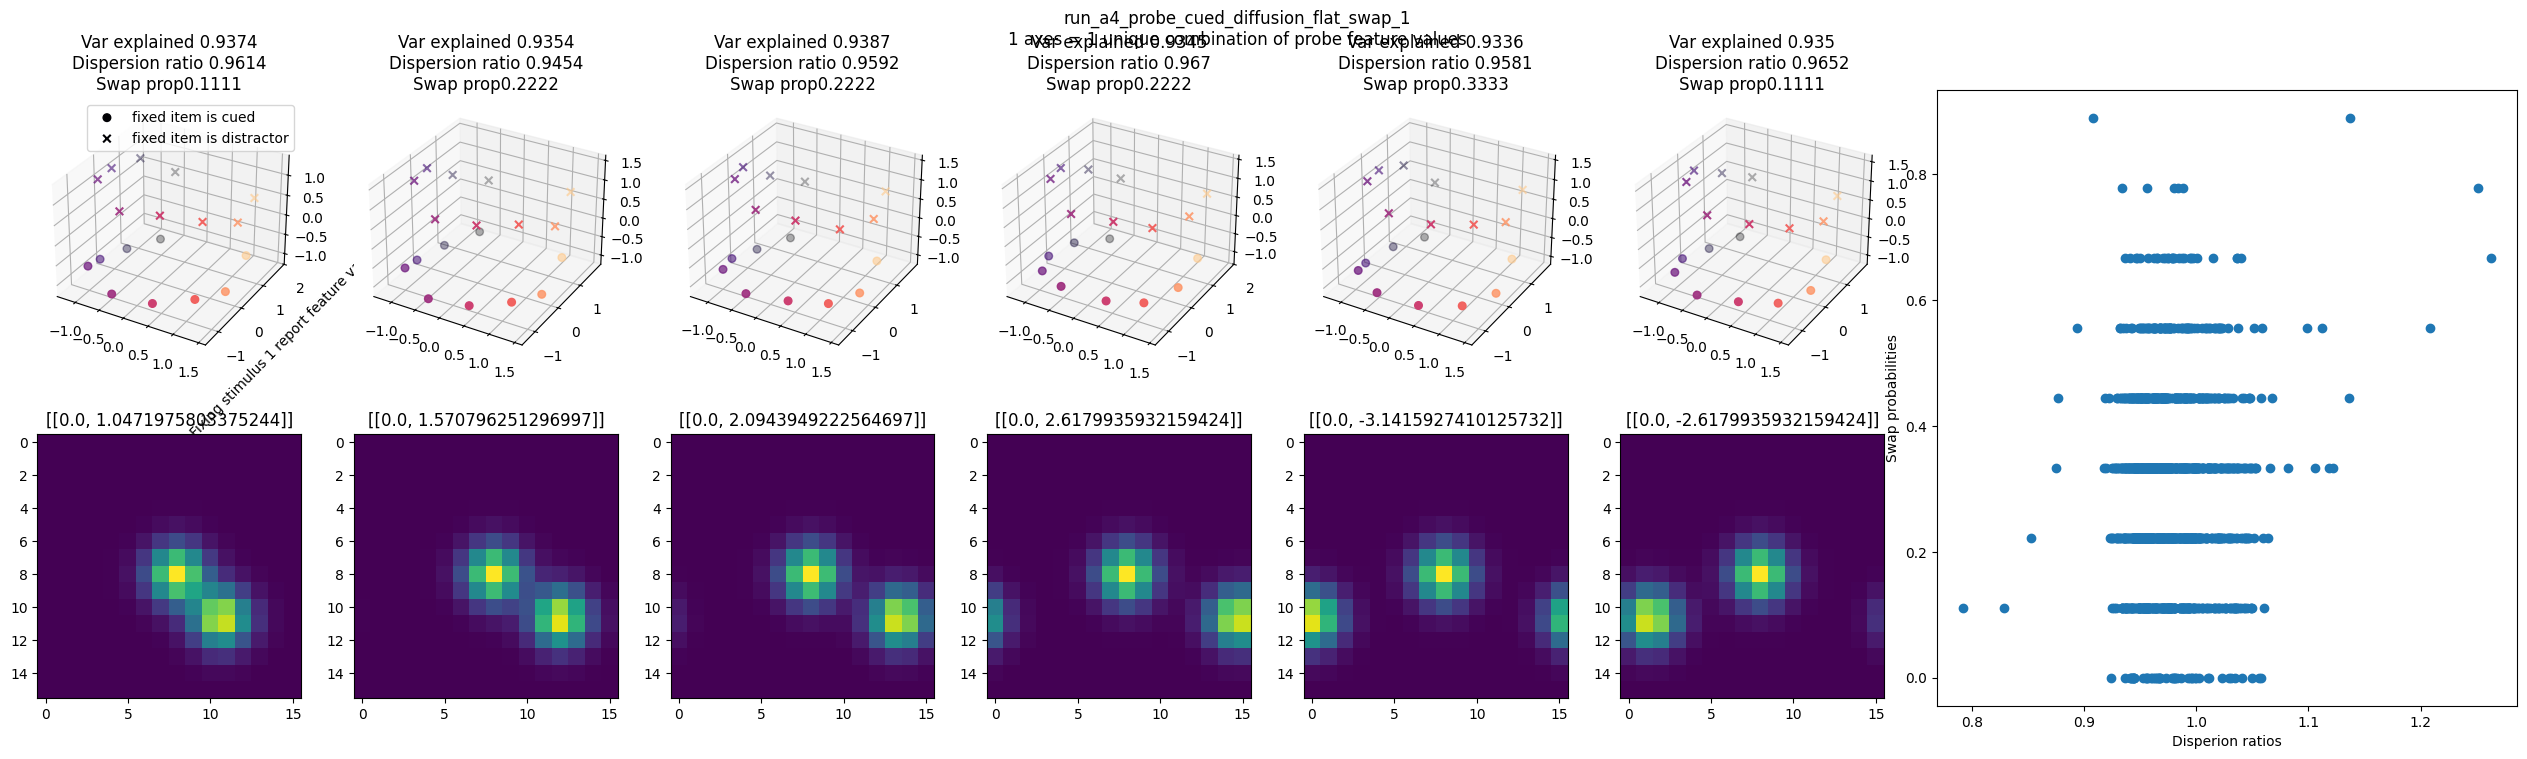

In [283]:
unique_probe_combinations = all_probe_features[::grid_points*grid_points]

# (novel_samples_dict['embedded_sample_trajectory'] @ ddpm_model.auxiliary_embedding_matrix.cpu().T) == novel_samples_dict['sample_trajectory']

pcaable_data = novel_samples_prep_dicts[3]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
# pcaable_data = novel_samples_prep_dicts[1]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
# pcaable_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.sample_subspace_accessor.cpu()
# pcaable_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-15,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()

num_probe_combs = 6

magma = plt.get_cmap("magma")
cNorm = colors.Normalize(vmin=0, vmax=9)
cmap = cmx.ScalarMappable(norm=cNorm, cmap=magma)
cmap_colors = torch.tensor([cmap.to_rgba(_) for _ in range(9)])
cmap.set_array([])

pca_dims = 3

ax_rows = 2
num_ax_cols = num_probe_combs
fig = plt.figure(figsize=(4 * num_ax_cols + 8, 4 * ax_rows))
gs = gridspec.GridSpec(ax_rows, num_ax_cols + 2)

# Create regular subplots
axes = [[fig.add_subplot(gs[r, c], projection='3d' if pca_dims > 2 and r == 0 else None) for c in range(num_ax_cols)] for r in range(ax_rows)]
axes = np.array(axes)
big_ax = fig.add_subplot(gs[:, -2:]) 

ic = -1

fig.suptitle(f'{run_name}\n1 axes = 1 unique combination of probe feature values')
axes[0,0].set_ylabel('Fixing stimulus 1 report feature value')


def avg_pairwise_distance(points):
    if len(points) < 2:
        return 0
    # pdist computes pairwise distances in a condensed form
    distances = pdist(points)
    return np.mean(distances)


all_swap_probs = []
all_dispersion_ratios = []

all_stim1_vals = []


for _j in tqdm(range(grid_points ** 2)):

    probe_comb = unique_probe_combinations[[_j]]
    both_probe_fixed_mask = (all_probe_features == probe_comb).all(-1)[valid_trial_mask]
    if not both_probe_fixed_mask.any():
        continue
    else:
        ic += 1


    if ic < num_probe_combs:
        axes[1,ic].imshow(trial_information.prep_network_inputs[0][both_probe_fixed_mask][0,0])
        axes[1,ic].set_title(probe_comb.tolist())


    for _k, fval in enumerate(unique_feature_values[:,None,None]):

        stim1_fixed_mask = (all_report_features[:,[0]] == fval).squeeze(-1)                     # All possible combinations
        stim1_and_probe_fixed_mask = both_probe_fixed_mask & stim1_fixed_mask[valid_trial_mask] # All valid combinations
        relevant_stim1_cued_mask = (selected_feature_idx_valid_trials == 0)[stim1_and_probe_fixed_mask] # Relevant trials

        pcaable_data_fixed_report1 = pcaable_data[stim1_and_probe_fixed_mask]                   # Relevant trials
        pca_obj_fixed_report1 = PCA(n_components=pca_dims, whiten = True).fit(pcaable_data_fixed_report1)
        pcaed_data = pca_obj_fixed_report1.transform(pcaable_data_fixed_report1)

        dispersion_ratio = avg_pairwise_distance(pcaed_data[relevant_stim1_cued_mask]) / avg_pairwise_distance(pcaed_data[~relevant_stim1_cued_mask])
        relevant_swapped_trials = swapped_trials[stim1_and_probe_fixed_mask]
        swap_prob = relevant_swapped_trials[relevant_stim1_cued_mask].float().mean().item()
        var_expl = pca_obj_fixed_report1.explained_variance_ratio_.sum().item()

        all_dispersion_ratios.append(dispersion_ratio)
        all_swap_probs.append(swap_prob)
        all_stim1_vals.append(all_report_features[:,[1]][stim1_fixed_mask & valid_trial_mask])

        if ic < num_probe_combs and _k == 0:
            axes[0,ic].scatter(*pcaed_data[relevant_stim1_cued_mask].T, s = 30, color = cmap_colors.numpy(), marker = 'o', label = 'fixed item is cued')
            axes[0,ic].scatter(*pcaed_data[~relevant_stim1_cued_mask].T, s = 30, color = cmap_colors.numpy(), marker = 'x', label = 'fixed item is distractor')
            axes[0,ic].set_title(f"Var explained {round(var_expl, 4)}\nDispersion ratio {round(dispersion_ratio, 4)}\nSwap prop{round(swap_prob, 4)}")
    
axes[0,0].legend()

big_ax.scatter(all_dispersion_ratios, all_swap_probs)
big_ax.set_xlabel('Disperion ratios')
big_ax.set_ylabel('Swap probabilities')

### Fix both probes and one report, then vary other report and seperate by probe and swap
#### Stopped doing this one - would require many trials

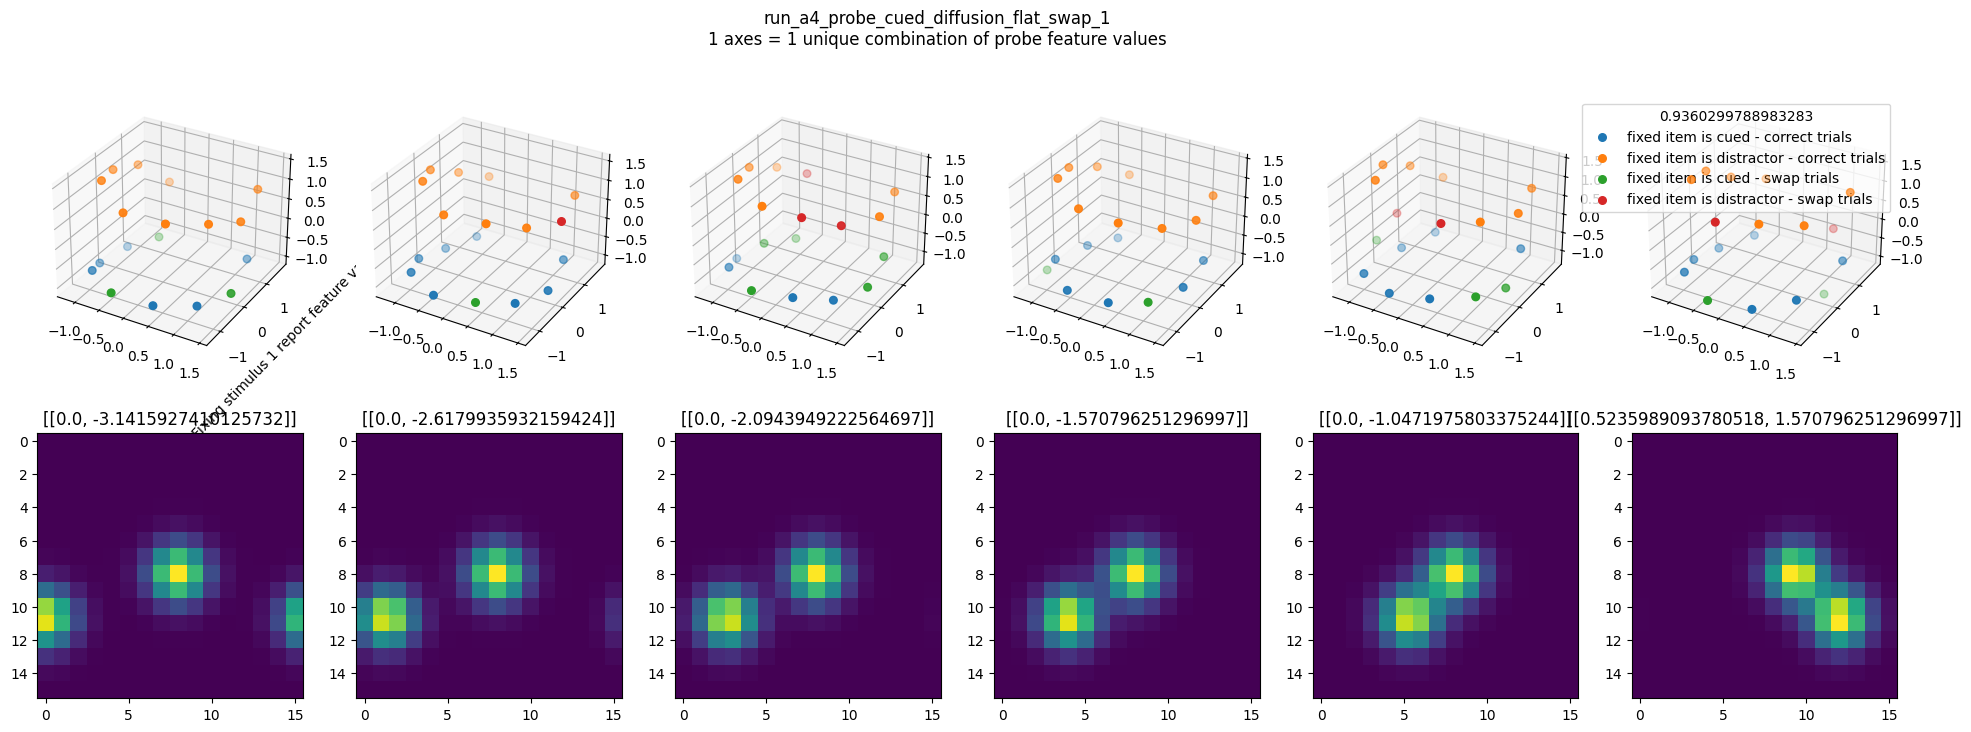

In [284]:
unique_probe_combinations = all_probe_features[::grid_points*grid_points]

# (novel_samples_dict['embedded_sample_trajectory'] @ ddpm_model.auxiliary_embedding_matrix.cpu().T) == novel_samples_dict['sample_trajectory']

pcaable_data = novel_samples_prep_dicts[3]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
# pcaable_data = novel_samples_prep_dicts[2]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
# pcaable_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-15,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.sample_subspace_accessor.cpu()
# pcaable_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-10,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()

num_probe_combs = 6

magma = plt.get_cmap("magma")
cNorm = colors.Normalize(vmin=0, vmax=9)
cmap = cmx.ScalarMappable(norm=cNorm, cmap=magma)
cmap_colors = torch.tensor([cmap.to_rgba(_) for _ in range(9)])
cmap.set_array([])

pca_dims = 3

ax_rows = 2
ax_cols = num_probe_combs
fig = plt.figure(figsize = (4 * num_probe_combs, 4 * ax_rows))
axes = [[fig.add_subplot(ax_rows, ax_cols, 1 + r * ax_cols + c, projection='3d' if pca_dims == 3 and r == 0 else None) for c in range(ax_cols)] for r in range(ax_rows)]
axes = np.array(axes)

ic = -1

fig.suptitle(f'{run_name}\n1 axes = 1 unique combination of probe feature values')
axes[0,0].set_ylabel('Fixing stimulus 1 report feature value')


for _j in range(6, grid_points ** 2):

    probe_comb = unique_probe_combinations[[_j]]
    both_probe_fixed_mask = (all_probe_features == probe_comb).all(-1)[valid_trial_mask]
    if not both_probe_fixed_mask.any():
        continue
    else:
        if ic == ax_cols - 1:
            break
        ic += 1


    axes[1,ic].imshow(trial_information.prep_network_inputs[0][both_probe_fixed_mask][0,0])
    axes[1,ic].set_title(probe_comb.tolist())


    for fval in unique_feature_values[:,None,None]:

        stim1_fixed_mask = (all_report_features[:,[0]] == fval).squeeze(-1)                     # All possible combinations
        stim1_and_probe_fixed_mask = both_probe_fixed_mask & stim1_fixed_mask[valid_trial_mask] # All valid combinations
        relevant_stim1_cued_mask = (selected_feature_idx_valid_trials == 0)[stim1_and_probe_fixed_mask] # All valid combinations

        pcaable_data_fixed_report1 = pcaable_data[stim1_and_probe_fixed_mask]                   # Relevant trials
        pca_obj_fixed_report1 = PCA(n_components=pca_dims, whiten = True).fit(pcaable_data_fixed_report1)
        pcaed_data = pca_obj_fixed_report1.transform(pcaable_data_fixed_report1)

        

        relevant_swapped_trials = swapped_trials[stim1_and_probe_fixed_mask] # All valid combinations


        axes[0,ic].scatter(*pcaed_data[relevant_stim1_cued_mask & ~relevant_swapped_trials].T, s = 30, label = 'fixed item is cued - correct trials')
        axes[0,ic].scatter(*pcaed_data[~relevant_stim1_cued_mask & ~relevant_swapped_trials].T, s = 30, label = 'fixed item is distractor - correct trials')
        axes[0,ic].scatter(*pcaed_data[relevant_stim1_cued_mask & relevant_swapped_trials].T, s = 30, label = 'fixed item is cued - swap trials')
        axes[0,ic].scatter(*pcaed_data[~relevant_stim1_cued_mask & relevant_swapped_trials].T, s = 30, label = 'fixed item is distractor - swap trials')

        break

axes[0,ic].legend(title = pca_obj_fixed_report1.explained_variance_ratio_.sum().item())


### Fix one probe, one report, and cue the fixed item. Then vary other item probe and report, and seperate by swapped

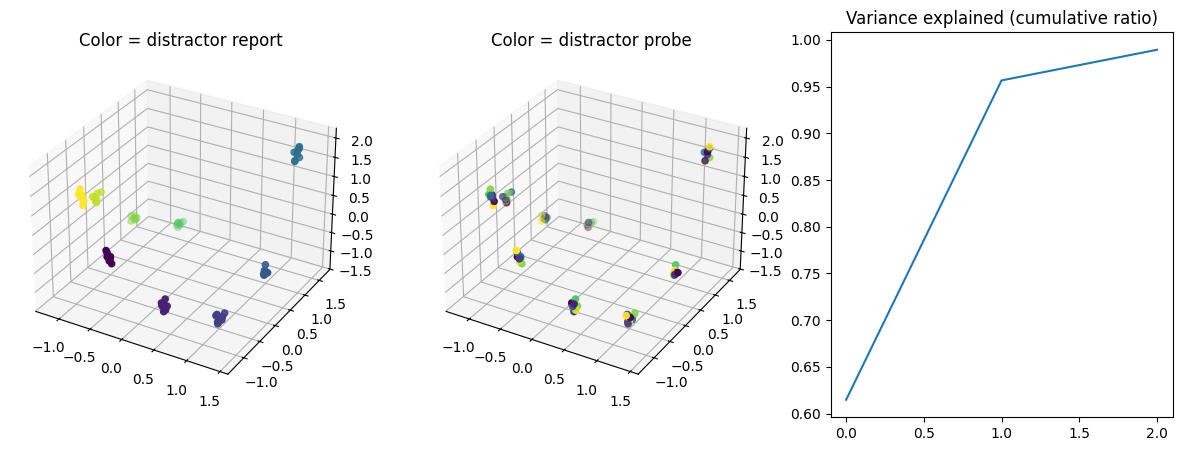

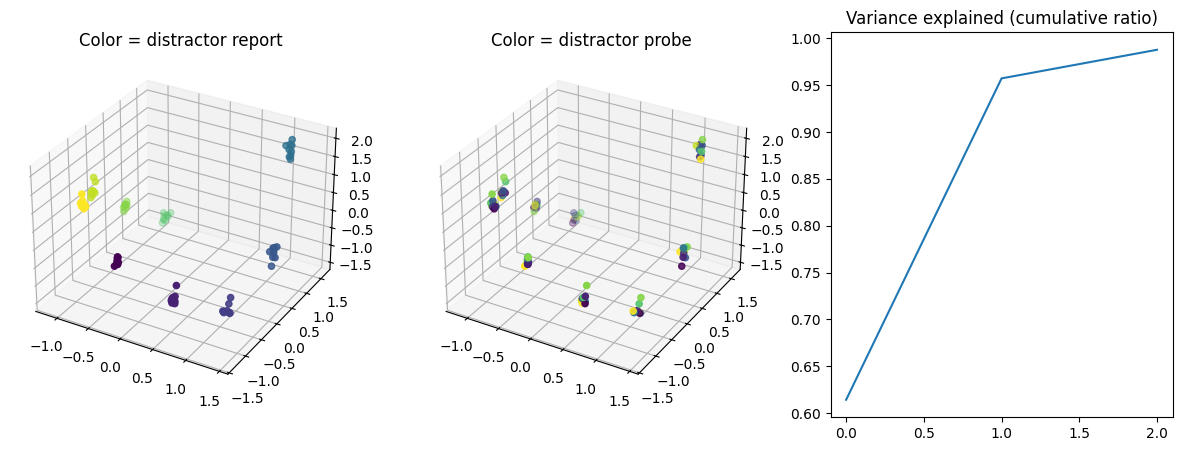

In [285]:
fixed_probe_val = 0.0
fixed_report_val = 0.0

fixed_stim1_trials_mask = ((all_report_features[:,0] == fixed_report_val) & (all_probe_features[:,0] == fixed_probe_val))

pcaable_data = novel_samples_prep_dicts[3]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
# pcaable_data = novel_samples_prep_dicts[1]['preparatory_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()
# pcaable_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-1,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.sample_subspace_accessor.cpu()
# pcaable_data = novel_samples_dict['embedded_sample_trajectory'].data[:,:,-15,:].cpu().reshape(batch_size * num_samples, -1) @ ddpm_model.behaviour_nullspace_accessor.cpu()


fixed_stim1_as_cued_data = pcaable_data[((selected_feature_idx == 0) & fixed_stim1_trials_mask)[valid_trial_mask]]
fixed_stim1_as_distractor_data = pcaable_data[((selected_feature_idx == 1) & fixed_stim1_trials_mask)[valid_trial_mask]]

stim2_report = all_report_features[valid_trial_mask][((selected_feature_idx == 0) & fixed_stim1_trials_mask)[valid_trial_mask]][:,1]
stim2_probe = all_probe_features[valid_trial_mask][((selected_feature_idx == 0) & fixed_stim1_trials_mask)[valid_trial_mask]][:,1]


pca_dim = 3

pca_obj_fixed_stim1_as_cued_data = PCA(n_components=pca_dim, whiten = True).fit(fixed_stim1_as_cued_data)
pcaed_fixed_stim1_as_cued_data = pca_obj_fixed_stim1_as_cued_data.transform(fixed_stim1_as_cued_data)

fig_stim1_as_cued = plt.figure(figsize = (15, 5))
ax_color_by_report = fig_stim1_as_cued.add_subplot(1, 3, 1, projection = '3d' if pca_dim == 3 else None)
ax_color_by_probe = fig_stim1_as_cued.add_subplot(1, 3, 2, projection = '3d' if pca_dim == 3 else None)
ax_var_explained = fig_stim1_as_cued.add_subplot(1, 3, 3)

ax_color_by_report.set_title('Color = distractor report')
ax_color_by_probe.set_title('Color = distractor probe')
ax_var_explained.set_title('Variance explained (cumulative ratio)')

ax_color_by_report.scatter(*pcaed_fixed_stim1_as_cued_data.T, c = stim2_report)
ax_color_by_probe.scatter(*pcaed_fixed_stim1_as_cued_data.T, c = stim2_probe)
ax_var_explained.plot(pca_obj_fixed_stim1_as_cued_data.explained_variance_ratio_.cumsum())






pca_obj_fixed_stim1_as_distractor_data = PCA(n_components=pca_dim, whiten = True).fit(fixed_stim1_as_distractor_data)
pcaed_fixed_stim1_as_distractor_data = pca_obj_fixed_stim1_as_distractor_data.transform(fixed_stim1_as_distractor_data)

fig_stim1_as_distractor = plt.figure(figsize = (15, 5))
ax_color_by_report = fig_stim1_as_distractor.add_subplot(1, 3, 1, projection = '3d' if pca_dim == 3 else None)
ax_color_by_probe = fig_stim1_as_distractor.add_subplot(1, 3, 2, projection = '3d' if pca_dim == 3 else None)
ax_var_explained = fig_stim1_as_distractor.add_subplot(1, 3, 3)

ax_color_by_report.set_title('Color = distractor report')
ax_color_by_probe.set_title('Color = distractor probe')
ax_var_explained.set_title('Variance explained (cumulative ratio)')

ax_color_by_report.scatter(*pcaed_fixed_stim1_as_distractor_data.T, c = stim2_report)
ax_color_by_probe.scatter(*pcaed_fixed_stim1_as_distractor_data.T, c = stim2_probe)
ax_var_explained.plot(pca_obj_fixed_stim1_as_distractor_data.explained_variance_ratio_.cumsum())

# Fix probes and run many trials -> swapping classifier analysis on cue & diffusion period

In [177]:
unique_probe_combinations[[6]]

tensor([[ 0.0000, -3.1416]])

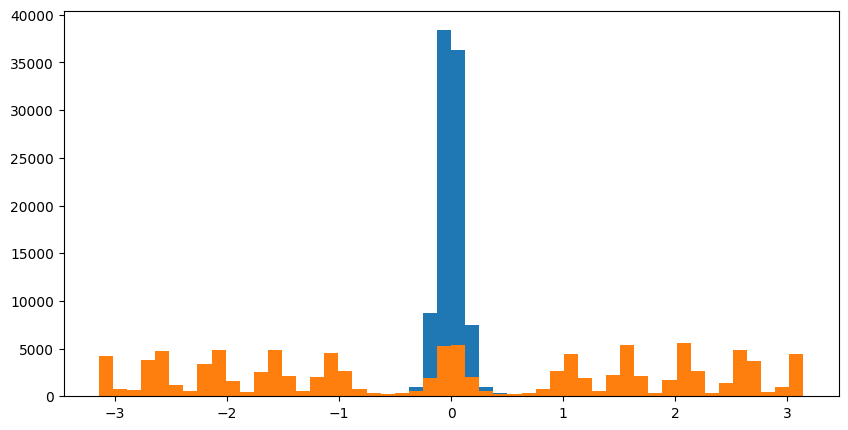

torch.Size([216, 512]) tensor(0.1512)


In [178]:
probe_comb = unique_probe_combinations[[6]]
both_probe_fixed_mask = (all_probe_features == probe_comb).all(-1)[valid_trial_mask]

override_stimulus_features = {
    'probe_features': all_probe_features[valid_trial_mask][both_probe_fixed_mask],
    'report_features': all_report_features[valid_trial_mask][both_probe_fixed_mask],
}
override_stimulus_cart_features = {}
for k in override_stimulus_features.keys():
    override_stimulus_cart_features[f'{k}_cart'] = torch.stack(polar2cart(1.0, override_stimulus_features[k]), -1)

override_stimulus_features_dict = dict(
    **override_stimulus_features,
    **override_stimulus_cart_features,
    cued_item_idx = selected_feature_idx_valid_trials[both_probe_fixed_mask]
)

fixed_probe_set_batch_size = both_probe_fixed_mask.sum()
num_samples_fixed_probes = 512

task_variable_dict = task.task_variable_gen.generate_variable_dict(
    batch_size = fixed_probe_set_batch_size,
    override_stimulus_features_dict=override_stimulus_features_dict
)

trial_information = task.generate_trial_information(
    batch_size = fixed_probe_set_batch_size, num_samples=num_samples_fixed_probes, override_task_variable_information = task_variable_dict
)

all_feature_data = torch.concat([
    trial_information.task_variable_information['probe_features_cart'].reshape(fixed_probe_set_batch_size, 4),
    trial_information.task_variable_information['report_features_cart'].reshape(fixed_probe_set_batch_size, 4),
], dim = -1)


with torch.no_grad():
    novel_samples_prep_dicts, novel_samples_dict = ddpm_model.generate_samples(
        # prep_network_inputs=[
        #     pni[[0]] for pni in trial_information.prep_network_inputs
        # ],
        # diffusion_network_inputs=[
        #     dni[[0]] for dni in trial_information.diffusion_network_inputs
        # ],
        prep_network_inputs = trial_information.prep_network_inputs,
        diffusion_network_inputs = trial_information.diffusion_network_inputs,
        prep_epoch_durations=trial_information.prep_epoch_durations,
        diffusion_epoch_durations=trial_information.diffusion_epoch_durations,
        samples_shape=[fixed_probe_set_batch_size, num_samples_fixed_probes],
        noise_scaler=1.0,
    )



actual_errors = rectify_angles(torch.arctan2(*novel_samples_dict['samples'][:,:,[1,0]].T).T - all_report_features[valid_trial_mask][both_probe_fixed_mask][range(both_probe_fixed_mask.sum()), selected_feature_idx[valid_trial_mask][both_probe_fixed_mask]].unsqueeze(1)).numpy()
swapped_errors = rectify_angles(torch.arctan2(*novel_samples_dict['samples'][:,:,[1,0]].T).T - all_report_features[valid_trial_mask][both_probe_fixed_mask][range(both_probe_fixed_mask.sum()), 1 - selected_feature_idx[valid_trial_mask][both_probe_fixed_mask]].unsqueeze(1)).numpy()

fig = plt.figure(figsize = (10, 5))
plt.hist(actual_errors.flatten(), 50)
plt.hist(swapped_errors.flatten(), 50)
plt.show()

swapped_trials = torch.tensor(np.abs(actual_errors) > np.abs(swapped_errors)).bool()
print(swapped_trials.shape, swapped_trials.float().mean())

In [179]:
many_trials_data = novel_samples_dict['embedded_sample_trajectory'].cpu() @ ddpm_model.behaviour_nullspace_accessor.cpu()

# many_trials_data_flattend = many_trials_data.reshape(fixed_probe_set_batch_size * num_samples_fixed_probes, ddpm_model.sample_ambient_dims[0])
# many_trials_data_flattend.shape
many_trials_num_report_combinations, _, num_ts, num_neurons = many_trials_data.shape

In [180]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

swapped_data = swapped_trials.int().cpu().numpy()


all_mcc = np.zeros((many_trials_num_report_combinations, num_ts))



for stim_idx in tqdm(range(many_trials_num_report_combinations)):

    train_idx, test_idx = train_test_split(
        np.arange(num_samples_fixed_probes),
        test_size=0.3, random_state=42, stratify=swapped_data[stim_idx]
    )
    swapped_train_data = swapped_data[stim_idx, train_idx]
    swapped_test_data = swapped_data[stim_idx, test_idx]

    for ts_idx in range(num_ts):

        trials_train_data = many_trials_data[stim_idx, train_idx, ts_idx, :].cpu().numpy()
        trials_test_data = many_trials_data[stim_idx, test_idx, ts_idx, :].cpu().numpy()
        
        clf = GaussianNB()
        clf.fit(trials_train_data, swapped_train_data)
        y_pred = clf.predict(trials_test_data)

        all_mcc[stim_idx, ts_idx] = matthews_corrcoef(swapped_test_data, y_pred)

100%|██████████| 216/216 [00:26<00:00,  8.11it/s]


(216, 40)


(array([ 1.,  1.,  2.,  5.,  2.,  4.,  4.,  0.,  9.,  3.,  2.,  6.,  2.,
         9.,  4.,  5.,  7.,  6.,  4.,  4.,  1.,  5.,  6.,  8., 13.,  7.,
         4.,  3.,  4.,  8.,  2.,  7.,  6.,  3.,  7.,  5.,  4.,  8.,  3.,
         1.,  4.,  3.,  6.,  2.,  4.,  3.,  3.,  2.,  1.,  3.]),
 array([-0.10957416, -0.09611122, -0.08264828, -0.06918534, -0.05572241,
        -0.04225947, -0.02879653, -0.01533359, -0.00187065,  0.01159229,
         0.02505523,  0.03851817,  0.05198111,  0.06544405,  0.07890698,
         0.09236992,  0.10583286,  0.1192958 ,  0.13275874,  0.14622168,
         0.15968462,  0.17314756,  0.1866105 ,  0.20007343,  0.21353637,
         0.22699931,  0.24046225,  0.25392519,  0.26738813,  0.28085107,
         0.29431401,  0.30777695,  0.32123989,  0.33470282,  0.34816576,
         0.3616287 ,  0.37509164,  0.38855458,  0.40201752,  0.41548046,
         0.4289434 ,  0.44240634,  0.45586927,  0.46933221,  0.48279515,
         0.49625809,  0.50972103,  0.52318397,  0.53664691,

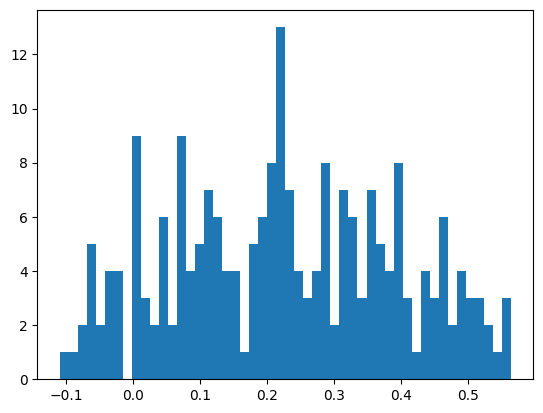

In [187]:
print(all_mcc.shape)
plt.hist(all_mcc[:,20], 50)

# Fixed point analysis

In [ ]:






def energy_function(neural_response: _T):
    delay_input = trial_information.prep_network_inputs[prep_epoch_idx]
    assert (delay_input == 0.0).all()
    time_embedding = ddpm_model.prep_time_embedding.expand(delay_duration, ddpm_model.prep_time_embedding.shape[1])
    network_input = ddpm_model.input_model(delay_input, delay_duration)
    xdot: _T = - neural_response + ddpm_model.residual_model(neural_response, time_embedding, network_input)
    return 0.5 * xdot.square().sum()


num_fp_opt_steps = 100000
activity_patterns = torch.nn.Parameter(delay_activity, requires_grad = True)
optim = torch.optim.Adam([activity_patterns], lr = 1e-2)

all_energies = []

for ots in tqdm(range(num_fp_opt_steps)):

    energy = energy_function(activity_patterns)
    total_energy = energy.mean()

    optim.zero_grad()
    total_energy.backward()
    optim.step()

    all_energies.append(total_energy.item())

    if ots % 100 == 0:

        plt.close('all')
        fig, axes = plt.subplots(2, 2, figsize = (20, 20))

        # Visualise PCA
        pcaable_data = activity_patterns.data[:,:,0,:].cpu().reshape(batch_size * num_samples, -1) # only one timestep rn
        pca = PCA(n_components=2, whiten = True).fit(pcaable_data)
        axes[0,1].scatter(*pca.transform(pcaable_data).T, c = color_array_flattened)

        # Visualise selected examples
        selected_pcaable_data = pcaable_data[only_stim2_changes_mask]
        pca_masked = PCA(n_components=2, whiten = True).fit(selected_pcaable_data)
        axes[1,0].scatter(*pca_masked.transform(selected_pcaable_data).T)

        # # Visualise CCA
        # item1_features = all_feature_data[:,[0,1,4,5]]
        # cca = CCA(n_components=2).fit(pcaable_data, item1_features)
        # activity_cross, stim_cross = cca.transform(pcaable_data, item1_features)
        # axes[1,0].scatter(*activity_cross.T, c = color_array_flattened)
        
        # Loss
        axes[0,0].plot(all_energies)
        
        fig.savefig('analysis/new_analysis/fixed_points_test.png')
